<h1>Introducing Decision Trees</h1>

The basic idea of decision trees is to use some simple segmentations of the feature space in order to produce accurate and interpretable predictions. We'll start by reviewing the basics of Decision Trees and then introduce ways to combine single decision trees into ensembles to produce more accurate predictions.

<h2>Regression Trees</h2>

When faced with the task of predicting a continuous variable we may choose to use a regression tree. In contrast to linear regression, a regression tree will make the claim that if variable $X_1$ satisfies some criteria the outcome is more likely to be near some value $\hat{y}$ -- in linear regression would would say a change in $X_1$ results in a proportionate change in the outcome $\hat{y}$.

In a decision tree we are effectively asking:
- if $X_1$ satisfies condition $z_1$:
    - if $X_2$ satisfies condition $z_2$:
        - ...
- else:
    - ...

We can visualize the decision making logic in a tree:

In [1]:
from treelib import Node, Tree

tree = Tree()

tree.create_node("All Data", "node1")  # No parent means its the root node
tree.create_node("X_1 > z_1",  "node2_1"   , parent="node1")
tree.create_node("X_1 <= z_1",  "node2_2"   , parent="node1")
tree.create_node("X_2 > z_2", "node3_1", parent="node2_1")
tree.create_node("X_2 <= z_2", "node3_2", parent="node2_1")
tree.create_node("X_3 > z_3", "node3_3", parent="node2_2")
tree.create_node("X_3 <= z_3", "node3_4", parent="node2_2")
tree.create_node("...", "node4_1", parent="node3_1")
tree.show()

All Data
├── X_1 <= z_1
│   ├── X_3 <= z_3
│   └── X_3 > z_3
└── X_1 > z_1
    ├── X_2 <= z_2
    └── X_2 > z_2
        └── ...



In the feature space of this problem these decisions amount to creating a set of $J$ partitions, where each outcome $\hat{y}$ lies in one of the partitions.

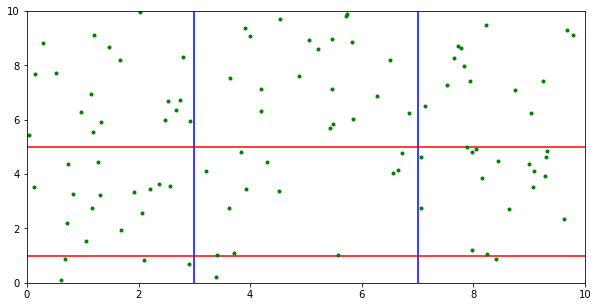

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 10, 0.01)
y = np.arange(0, 10, 0.01)
x_plot = np.random.choice(x, size=100, replace=False)
y_plot = np.random.choice(y, size=100, replace=False)

# specifying the plot size
plt.figure(figsize = (10, 5))
 
# only one line may be specified; full height
plt.axvline(x = 7, color = 'b')
plt.axvline(x = 3, color = 'b')
plt.axhline(y = 1, color = 'r')
plt.axhline(y = 5, color = 'r')
plt.plot(x_plot, y_plot, 'g.')
 
# rendering plot
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

Given this partition, how would we make a prediction for a new value?

We could just predict the mean of the values contained in the partition.

Now that we know the goal (to partition the feature space) how do we go about picking the best partitions?

As with our other models, we'll construct a loss function and attempt to optimize it:
$$ RSS = \sum_j\sum_i (y_i - \hat{y}_{R_j})^2$$
where $R_j$ is the $j$th partition and $i$ is the data point.

We can take a naive approach to this problem and perform a grid serach over all of the possible partitions. BUT this will be incredibly slow -- if you thought linear regression was bad, this is worse (we have the feature and the decision criteria we need to search over).

In fact, we could pick an infinite number of decision criteria and construct arbitrarily many partitions. Clearly, we need a "smart" approach to partitioning the feature space so that we can arrive at a good enough solution.

We will use a recursive, "top-down", and greedy approach to finding the optimal partitions:
- construct one partition that minimizes the $RSS$
- from those nodes/leafs, construct the next partition

In each step we are optimizing for creating the next partition such that it provides the greatest reduction in RSS. In this approach we need to select two parameters in each step -- the feature $X_i$ that we use and the decision criteria $z_j$. We will also need to introduce a stopping criteria -- a way to make it so our algorithm terminates -- so that we don't arrive at an overfit solution (partitions that are too small, contain too few points, etc).

Let's see how this works in practice:

In [2]:
import pandas as pd
import plotly.express as px
df = pd.read_csv("CarPrice_Assignment.csv")
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
df.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

In [4]:
y = np.asarray(df['price'].values)
X = np.asarray(df[['wheelbase','carlength','curbweight','enginesize','citympg']].values)
print(len(X))
print(len(X[0]))

205
5


In [5]:
def RSS_partition(y):
    avg_y = np.mean(y)
    rss = 0
    for i in y:
        rss += (i - avg_y)**2
    return rss

In [6]:
def create_partition(X, y, split):
    y1 = []
    y2 = []
    for i in range(len(X)):
        if X[i] > split:
            y1.append(y[i])
        else:
            y2.append(y[i])
    return y1, y2

In [7]:
def get_splits(X, num_splits):
    list_min = np.min(X)
    list_max = np.max(X)
    return np.arange(list_min, list_max, (list_max-list_min)/num_splits)

In [8]:
out_list = []
for j in range(len(X[0])):
    for i in get_splits(X[:,j], 10):
        y1, y2 = create_partition(X[:,j], y, i)
        rss = RSS_partition(y1) + RSS_partition(y2)
        out_list.append([j,i,rss])
df_partition = pd.DataFrame(out_list, columns=['feature','split','rss'])
df_partition.sort_values('rss', ascending=True).head()

,feature,split,rss
35,3,193.5,5.293088e+09
34,3,167.0,6.012227e+09
24,2,2519.2,7.080367e+09
27,2,3292.6,7.161764e+09
25,2,2777.0,7.203090e+09


We see here the best splits to apply that will reduce the RSS the most. To continue the algorithm we would choose the first split and then run the algorithm on the newly created partitions and continue until we reach the stopping criterion.

<h2>Classification Trees</h2>

The algorithm remains the same for classification, however the metric changes. In classification we want to instead maximize the purity of the partitions. We measure purity qualitatively by looking for partitions where the majority of the points are from one class. We can express this analytically in the Gini index:
$$G=\sum p_{km}(1-p_{km})$$
or in the Entropy:
$$D=-\sum p_{km}\log{p_{km}}$$
where $p_{km}$ is the proportion of observations in partition $m$ belonging to class $k$.

<h2>Pruning Trees</h2>

Growing trees in this way can lead to good predictions but will also often lead to overfitting. We would like to take advantage of the accuracy we get in the greedy algorithm we've described but allow our trees to generalize more easily. We can accomplish this by a technique called pruning. Effectively we remove splits from our tree to remove some of the bias.

We will basically remove a node (turn a node into a leaf) creating a series of trees constructed from the original large tree (each sub tree is contained within the original tree). And then we will choose the optimal subtree such that 
$$ RSS = \sum_j\sum_i (y_i - \hat{y}_{R_j})^2 + \alpha |T|$$
This is similar to regularization in linear regression.

<h2>Hyperparameters for Decision Trees</h2>

In the out of the box implementations of trees there are a number of hyperparameters to choose that specify how the algorithm will grow the tree. In Sklearn, the hyperparameters are (effectively):
- max_depth -- how deep to grow the tree
- min_samples_split -- how many samples are required in a node in order to split on it
- min_samples_leaf -- the minimum number of samples required to be at a leaf node

And then other variations on these hyperparameters. The basic idea is that we want to control how many leaf nodes we have in our tree and how many samples are contained within them -- we don't want to just have one observation in the leaf nodes of our tree as that is an example of overfitting.
